# Respecting Architecture Connectivity Constraints - Advanced Routing in tket

Very few current or planned quantum architectures have all-to-all qubit connectivity. In consequence, quantum circuits must be modified before execution to ensure that every multi-qubit gate in a circuit corresponds to a set of interactions that are permitted by the architecture.  The problem is solved for arbitrary architectures by adding ```SWAP``` gates and distributed ```CX``` gates, and through translation of multi-qubit gates in to architecture permitted ones.<br>
<br>
In this tutorial we will show how this routing problem is solved automatically in tket. The basic examples require only the installation of pytket, ```pip install pytket```, while further examples require the installation of some supported subpackages, ```pytket_qiskit``` & ```pytket_cirq```.<br>
<br>
Let's start by importing the Architecture class from ```pytket```:

In [1]:
from pytket.routing import Architecture

The Architecture class is used in ```pytket``` to hold information about a quantum architectures connectivity constraints. An Architecture object requires a coupling map to be created i.e. a list of edges between qubits which defines where two-qubit primitives may be executed. A coupling map can be produced naively by the integer indexing of nodes and edges in your architecture. We also use networkx and matplotlib to draw a graph representation of our Architecture.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
def draw_graph(coupling_map):
    coupling_graph = nx.Graph(coupling_map)
    nx.draw(coupling_graph, labels={node: node for node in coupling_graph.nodes()})

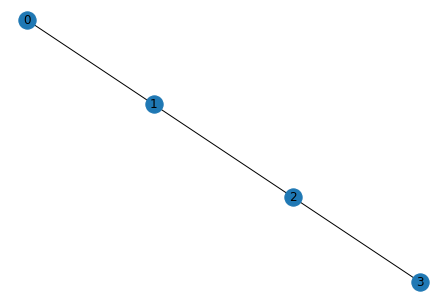

In [4]:
simple_coupling_map = [(0, 1), (1, 2), (2, 3)]
simple_architecture = Architecture(simple_coupling_map)
draw_graph(simple_coupling_map)

Alternatively we could use the `Node` class to assign our nodes - you will see why this can be helpful later. Lets create an Architecture with an identical graph in this manner.

In [5]:
from pytket.circuit import Node

In [6]:
node_0 = Node("example_register", 0)
node_1 = Node("example_register", 1)
node_2 = Node("example_register", 2)
node_3 = Node("example_register", 3)

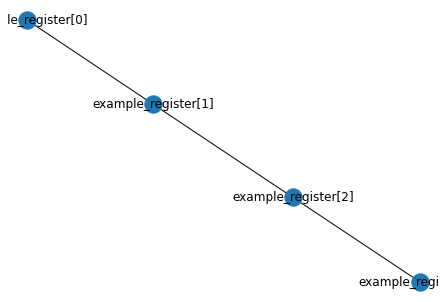

In [7]:
id_coupling_map = [(node_0, node_1), (node_1, node_2), (node_2, node_3)]
id_architecture = Architecture(id_coupling_map)
draw_graph(id_coupling_map)

We can also create an ID with an arbitrary-dimensional index. Lets make a 2x2x2 cube:

In [8]:
node_000 = Node("cube", [0, 0, 0])
node_001 = Node("cube", [0, 0, 1])
node_010 = Node("cube", [0, 1, 0])
node_011 = Node("cube", [0, 1, 1])
node_100 = Node("cube", [1, 0, 0])
node_101 = Node("cube", [1, 0, 1])
node_110 = Node("cube", [1, 1, 0])
node_111 = Node("cube", [1, 1, 1])

In [9]:
cube_coupling_map = [
    (node_000, node_001),
    (node_000, node_010),
    (node_010, node_011),
    (node_001, node_011),
    (node_000, node_100),
    (node_001, node_101),
    (node_010, node_110),
    (node_011, node_111),
    (node_100, node_101),
    (node_100, node_110),
    (node_110, node_111),
    (node_101, node_111),
]

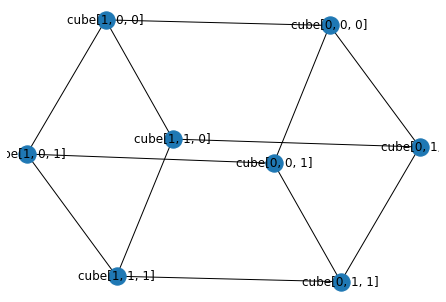

In [10]:
cube_architecture = Architecture(cube_coupling_map)
draw_graph(cube_coupling_map)

To avoid that tedium though we could just use our SquareGrid Architecture:

In [11]:
from pytket.routing import SquareGrid

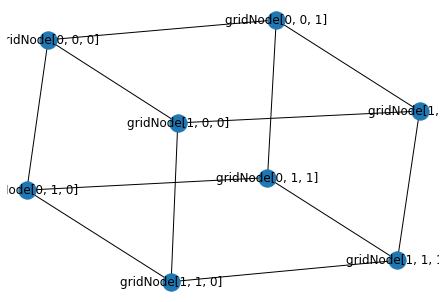

In [12]:
alternative_cube_architecture = SquareGrid(2, 2, 2)
draw_graph(alternative_cube_architecture.coupling)

In many cases, we are interested in the architectures of real devices. These are available directly from the device backends, available within tket's respective extension packages. 

In reality a Quantum Device has much more information to it than just its connectivity constraints. <br>
This includes information we can use in noise-aware methods such as gate errors and readout errors for each qubit. These methods can improve circuit performance when running on real hardware. If available from hardware providers, a device Backend will store this information via a `BackendInfo` attribute.

In [13]:
from qiskit import IBMQ

In [14]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

We can produce an IBMQ Backend object using ```process_characterisation```. This returns a dictionary containing characteriastion informatino provided by IBMQ, including t1 times, t2 times, qubit frequencies and gate times along with the coupling graph of the device as a pytket ```Architecture```.

In [15]:
from pytket.circuit import OpType
from pytket.extensions.qiskit.qiskit_convert import process_characterisation

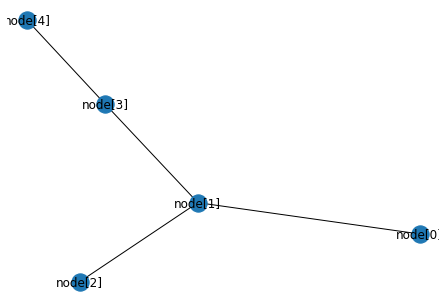

In [16]:
provider = IBMQ.providers()[0]
quito_backend = provider.get_backend("ibmq_quito")
quito_characterisation = process_characterisation(quito_backend)
draw_graph(quito_characterisation["Architecture"].coupling)

This characterisation contains a range of information such as gate fidelities. Let's look at two-qubit gate errors.

In [17]:
for key, val in quito_characterisation["EdgeErrors"].items():
    print(key, val)

(node[3], node[4]) {<OpType.CX: 37>: 0.033269963746661635}
(node[4], node[3]) {<OpType.CX: 37>: 0.016634981873330817}
(node[1], node[3]) {<OpType.CX: 37>: 0.016052126355634244}
(node[3], node[1]) {<OpType.CX: 37>: 0.008026063177817122}
(node[2], node[1]) {<OpType.CX: 37>: 0.01547981204259763}
(node[1], node[2]) {<OpType.CX: 37>: 0.007739906021298815}
(node[0], node[1]) {<OpType.CX: 37>: 0.01339685846043187}
(node[1], node[0]) {<OpType.CX: 37>: 0.006698429230215935}


We've now seen how to create custom Architectures using indexing and nodes, how to use our built in Architecture generators for typical connectivity graphs and how to access characterisation information using the ```process_characterisation``` method.<br>
<br>
Let's now see how we can use these objects are used for Routing circuits - we create a circuit for Routing to our original architectures and assume the only primitive constraint is the ```CX``` gate, which can only be executed on an edge in our coupling map.

In [18]:
from pytket import Circuit

In [19]:
example_circuit = Circuit(4)
example_circuit.CX(0, 1).CX(0, 2).CX(1, 2).CX(3, 2).CX(0, 3)
for gate in example_circuit:
    print(gate)

CX q[0], q[1];
CX q[0], q[2];
CX q[1], q[2];
CX q[3], q[2];
CX q[0], q[3];


We can also visualise the `Circuit` using, for example, IBM Qiskit's `QuantumCircuit` printer. To do this, we must use the `pytket.extensions.qiskit` subpackage and import a method from within Qiskit.

In [20]:
from pytket.extensions.qiskit import tk_to_qiskit

In [21]:
print(tk_to_qiskit(example_circuit))

                              
q_0: ──■────■──────────────■──
     ┌─┴─┐  │              │  
q_1: ┤ X ├──┼────■─────────┼──
     └───┘┌─┴─┐┌─┴─┐┌───┐  │  
q_2: ─────┤ X ├┤ X ├┤ X ├──┼──
          └───┘└───┘└─┬─┘┌─┴─┐
q_3: ─────────────────■──┤ X ├
                         └───┘


This circuit can not be executed on any of our Architectures without modification. We can see this by looking at the circuits interaction graph, a graph where nodes are logical qubits and edges are some two-qubit gate.

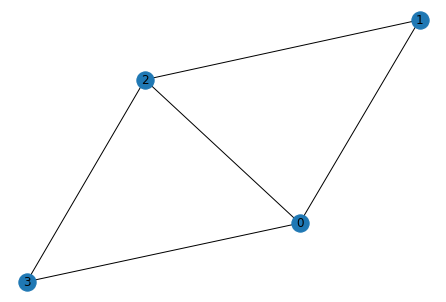

In [22]:
interaction_edges = [(0, 1), (0, 2), (1, 2), (3, 2), (0, 3)]
draw_graph(interaction_edges)

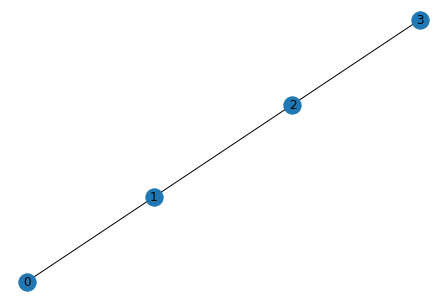

In [23]:
draw_graph(simple_coupling_map)

Sometimes we can route a circuit just by labelling the qubits to nodes of our Architecture such that the interaction graph matches a subgraph of the Architecture - unfortunately this isn't possible here.<br>
<br>
Let's call ```pytket```'s automatic routing method, route our circuit for the first Architecture we made, and have a look at our new circuit:

In [24]:
from pytket.routing import route

In [25]:
simple_modified_circuit = route(example_circuit, simple_architecture)

In [26]:
for gate in simple_modified_circuit:
    print(gate)

CX node[1], node[0];
CX node[1], node[2];
SWAP node[0], node[1];
CX node[1], node[2];
SWAP node[0], node[1];
CX node[3], node[2];
SWAP node[1], node[2];
CX node[2], node[3];


In [27]:
print(tk_to_qiskit(simple_modified_circuit))

        ┌───┐                          
node_0: ┤ X ├──────X────────X──────────
        └─┬─┘      │        │          
node_1: ──■────■───X───■────X───X──────
             ┌─┴─┐   ┌─┴─┐┌───┐ │      
node_2: ─────┤ X ├───┤ X ├┤ X ├─X───■──
             └───┘   └───┘└─┬─┘   ┌─┴─┐
node_3: ────────────────────■─────┤ X ├
                                  └───┘


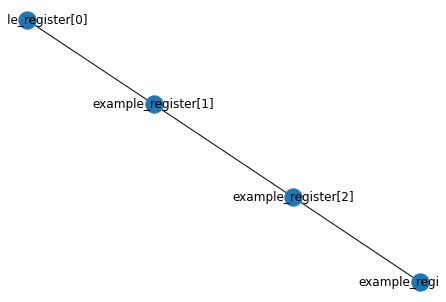

In [28]:
draw_graph(id_architecture.coupling)

The route method has relabelled the qubits in our old circuit to nodes in simple_architecture, and has added ```SWAP``` gates that permute logical qubits on nodes of our Architecture.<br>
<br>
Let's repeat this for id_architecture:

In [29]:
id_modified_circuit = route(example_circuit, id_architecture)

In [30]:
for gate in id_modified_circuit:
    print(gate)

CX example_register[1], example_register[0];
CX example_register[1], example_register[2];
SWAP example_register[0], example_register[1];
CX example_register[1], example_register[2];
SWAP example_register[0], example_register[1];
CX example_register[3], example_register[2];
SWAP example_register[1], example_register[2];
CX example_register[2], example_register[3];


In [31]:
print(tk_to_qiskit(id_modified_circuit))

                    ┌───┐                          
example_register_0: ┤ X ├──────X────────X──────────
                    └─┬─┘      │        │          
example_register_1: ──■────■───X───■────X───X──────
                         ┌─┴─┐   ┌─┴─┐┌───┐ │      
example_register_2: ─────┤ X ├───┤ X ├┤ X ├─X───■──
                         └───┘   └───┘└─┬─┘   ┌─┴─┐
example_register_3: ────────────────────■─────┤ X ├
                                              └───┘


Both simple_architecture and id_architecture had the same graph structure, and so we can see that the qubits have been relabelled and ```SWAP``` gates added identically - the only difference is the preservation of the node labelling of id_architecture.<br>
<br>
Let's repeat this one more time for cube_architecture:

In [32]:
cube_modified_circuit = route(example_circuit, cube_architecture)

In [33]:
for gate in cube_modified_circuit:
    print(gate)

CX cube[0, 0, 0], cube[0, 0, 1];
CX cube[0, 0, 0], cube[0, 1, 0];
SWAP cube[0, 0, 0], cube[0, 0, 1];
CX cube[0, 0, 0], cube[0, 1, 0];
CX cube[0, 1, 1], cube[0, 1, 0];
CX cube[0, 0, 1], cube[0, 1, 1];


In [34]:
cmc_copy = cube_modified_circuit.copy()
cmc_copy.flatten_registers()
print(tk_to_qiskit(cmc_copy))

                                 
q_0: ──■────■───X───■────────────
     ┌─┴─┐  │   │   │            
q_1: ┤ X ├──┼───X───┼─────────■──
     └───┘┌─┴─┐   ┌─┴─┐┌───┐  │  
q_2: ─────┤ X ├───┤ X ├┤ X ├──┼──
          └───┘   └───┘└─┬─┘┌─┴─┐
q_3: ────────────────────■──┤ X ├
                            └───┘


Similarly the circuits qubits have been relabelled and ```SWAP``` gates added. In this example though ```route``` is able to utilise the extra connectivity of cube_architecture to reduce the number of ```SWAP``` gates added from 3 to 1.<br>
<br>
We also route for the Quito architecture. 

In [35]:
quito_modified_circuit = route(example_circuit, quito_characterisation["Architecture"])

In [36]:
for gate in quito_modified_circuit:
    print(gate)

CX node[1], node[0];
CX node[1], node[2];
SWAP node[0], node[1];
CX node[1], node[2];
SWAP node[1], node[3];
CX node[1], node[2];
CX node[0], node[1];


In [37]:
print(tk_to_qiskit(quito_modified_circuit))

        ┌───┐                          
node_0: ┤ X ├──────X────────────────■──
        └─┬─┘      │              ┌─┴─┐
node_1: ──■────■───X───■───X───■──┤ X ├
             ┌─┴─┐   ┌─┴─┐ │ ┌─┴─┐└───┘
node_2: ─────┤ X ├───┤ X ├─┼─┤ X ├─────
             └───┘   └───┘ │ └───┘     
node_3: ───────────────────X───────────
                                       


The ```route``` method comes with a set of parameters that can be modified to tune the performance of routing for a circuit to a given Architecture.<br>
<br>
The 6 parameters are as follows:<br>
- (int) **swap_lookahead**, the depth of lookahead employed when trialling ```SWAP``` gates during Routing, default 50.<br>
- (int) **bridge_lookahead**, the depth of lookahead employed when comparing ```BRIDGE``` gates to ```SWAP``` gates during Routing, default 2.<br>
- (int) **bridge_interactions**, the number of interactions considered in a slice of multi-qubit gates when comparing ```BRIDGE``` gates to ```SWAP``` gates during routing, default 1.<br>
- (float) **bridge_exponent**, effects the weighting placed on future slices when comparing ```BRIDGE``` gates to ```SWAP``` gates, default 0.

Let's change some of our basic routing parameters:

In [38]:
basic_parameters = dict(bridge_lookahead=4, bridge_interactions=4, swap_lookahead=0)
id_basic_modified_circuit = route(example_circuit, id_architecture, **basic_parameters)

In [39]:
for gate in id_basic_modified_circuit:
    print(gate)

CX example_register[1], example_register[0];
CX example_register[1], example_register[2];
SWAP example_register[1], example_register[2];
CX example_register[0], example_register[1];
BRIDGE example_register[3], example_register[2], example_register[1];
CX example_register[2], example_register[3];


By changing the basic routing parameters we return a different routed circuit. To assess performance we must know the CX decomposition of both the ```SWAP``` and ```BRIDGE``` gates.

In [40]:
SWAP_c = Circuit(2)
SWAP_c.SWAP(0, 1)
SWAP_decomp_c = Circuit(2)
SWAP_decomp_c.CX(0, 1).CX(1, 0).CX(0, 1)
BRIDGE_c = Circuit(3)
BRIDGE_c.CX(0, 2)
BRIDGE_decomp_c = Circuit(3)
BRIDGE_decomp_c.CX(0, 1).CX(1, 2).CX(0, 1).CX(1, 2)

[CX q[0], q[1]; CX q[1], q[2]; CX q[0], q[1]; CX q[1], q[2]; ]

In [41]:
print(tk_to_qiskit(SWAP_c), "\n=\n", tk_to_qiskit(SWAP_decomp_c))
print(tk_to_qiskit(BRIDGE_c), "\n=\n", tk_to_qiskit(BRIDGE_decomp_c))

        
q_0: ─X─
      │ 
q_1: ─X─
         
=
           ┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘
          
q_0: ──■──
       │  
q_1: ──┼──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘ 
=
                          
q_0: ──■─────────■───────
     ┌─┴─┐     ┌─┴─┐     
q_1: ┤ X ├──■──┤ X ├──■──
     └───┘┌─┴─┐└───┘┌─┴─┐
q_2: ─────┤ X ├─────┤ X ├
          └───┘     └───┘


The ```BRIDGE``` (or Distributed-CX gate distance 2) and ```SWAP``` both introduce a net three ```CX``` gates to the circuit.<br>
<br>
Considering this, by changing our basic parameters our routed circuit has one less gate added, and so should have net three fewer ```CX``` gates. We can confirm this by calling a ```Transformation``` pass that will decompose our additional gates to ```CX``` gates for us.

In [42]:
from pytket.transform import Transform

In [43]:
Transform.DecomposeSWAPtoCX().apply(id_modified_circuit)
Transform.DecomposeSWAPtoCX().apply(id_basic_modified_circuit)
Transform.DecomposeBRIDGE().apply(id_basic_modified_circuit)

True

In [44]:
print(
    "CX gates in id_modified_circuit: ", id_modified_circuit.n_gates_of_type(OpType.CX)
)
print(
    "CX gates in id_basic_modified_circuit: ",
    id_basic_modified_circuit.n_gates_of_type(OpType.CX),
)

CX gates in id_modified_circuit:  14
CX gates in id_basic_modified_circuit:  11


So, by changing the parameters we've managed to produce another suitable routed solution with three fewer ```CX``` gates.<br>
<br>
We may be able to reduce the number of ```CX``` gates in our routed circuits by using the ```RemovedRedundancies``` ```Transformation``` pass which will replace any adjacent identical ```CX``` gates with the Identity and remove them.

In [45]:
Transform.RemoveRedundancies().apply(id_modified_circuit)
Transform.RemoveRedundancies().apply(id_basic_modified_circuit)

True

In [46]:
print(
    "CX gates in id_modified_circuit: ", id_modified_circuit.n_gates_of_type(OpType.CX)
)
print(
    "CX gates in id_basic_modified_circuit: ",
    id_basic_modified_circuit.n_gates_of_type(OpType.CX),
)

CX gates in id_modified_circuit:  14
CX gates in id_basic_modified_circuit:  9


By changing the routing parameters and cleaning up our circuits after routing we've managed to reduce the number of ```CX``` gates in the final circuit by 5!

In [47]:
print(tk_to_qiskit(id_modified_circuit))
print(tk_to_qiskit(id_basic_modified_circuit))

                    ┌───┐          ┌───┐               ┌───┐               »
example_register_0: ┤ X ├───────■──┤ X ├──■─────────■──┤ X ├──■────────────»
                    └─┬─┘     ┌─┴─┐└─┬─┘┌─┴─┐     ┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐»
example_register_1: ──■────■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├»
                         ┌─┴─┐└───┘     └───┘┌─┴─┐├───┤     └───┘┌─┴─┐└─┬─┘»
example_register_2: ─────┤ X ├───────────────┤ X ├┤ X ├──────────┤ X ├──■──»
                         └───┘               └───┘└─┬─┘          └───┘     »
example_register_3: ────────────────────────────────■──────────────────────»
                                                                           »
«                              
«example_register_0: ──────────
«                              
«example_register_1: ──■───────
«                    ┌─┴─┐     
«example_register_2: ┤ X ├──■──
«                    └───┘┌─┴─┐
«example_register_3: ─────┤ X ├
«                         └───┘
                   

We can also confirm their validity:

In [48]:
print(id_modified_circuit.valid_connectivity(id_architecture, False))
print(id_basic_modified_circuit.valid_connectivity(id_architecture, False))

True
True


Some circuits may not have bidirectional edges between qubits. We can check that our circuits respect unidirectional device edges by changing the directed flag in the ```Circuit.valid_connectivity``` method to True:

In [49]:
print(id_modified_circuit.valid_connectivity(id_architecture, True))
print(id_basic_modified_circuit.valid_connectivity(id_architecture, True))

False
False


Neither of these circuits respect the id_architecture if its coupling map had a directed constraint. We can easily make them satisfy this constraint though by flipping the direction of some ```CX``` gates and adding ```H``` gates as suitable. The ```Transform``` pass ```DecomposeCXDirected``` does this automatically:

In [50]:
Transform.DecomposeCXDirected(id_architecture).apply(id_modified_circuit)
Transform.DecomposeCXDirected(id_architecture).apply(id_basic_modified_circuit)

True

In [51]:
print(id_modified_circuit.valid_connectivity(id_architecture, True))
print(id_basic_modified_circuit.valid_connectivity(id_architecture, True))

True
True


In [52]:
print("Total gates in id_modified_circuit: ", id_modified_circuit.n_gates)
print("Total gates in id_basic_modified_circuit: ", id_basic_modified_circuit.n_gates)

Total gates in id_modified_circuit:  34
Total gates in id_basic_modified_circuit:  33


As each flipped ```CX``` gate introduces 4 ```H``` gates, the number of additional ```H``` gates is large.<br>
<br>
We can reapply ```RemoveRedundancies``` to improve this.

In [53]:
Transform.RemoveRedundancies().apply(id_modified_circuit)
Transform.RemoveRedundancies().apply(id_basic_modified_circuit)

True

In [54]:
print("Total gates in id_modified_circuit: ", id_modified_circuit.n_gates)
print("Total gates in id_basic_modified_circuit: ", id_basic_modified_circuit.n_gates)

Total gates in id_modified_circuit:  34
Total gates in id_basic_modified_circuit:  21


We can see that by changing our basic parameters, we've managed to significantly improve routing performance for a directed architecture for this example.<br>
<br>
We can also use Placement objects to relabel logical circuit qubits to physical device qubits before routing, hopefully improving performance by reducing eventual number of ```SWAP``` gates added. Available options are ```Placement``` (as used by default route), ```LinePlacement```, ```GraphPlacement``` and ```NoiseAwarePlacement```.

In [55]:
from pytket.routing import Placement, LinePlacement, GraphPlacement, NoiseAwarePlacement

The default ```Placement``` assigns logical qubits to physical qubits as they are encountered during routing. ```LinePlacement``` uses a strategy described in https://arxiv.org/abs/1902.08091. ```GraphPlacement``` and ```NoiseAwarePlacement``` are described in Section 7.1 of https://arxiv.org/abs/2003.10611. The ```NoiseAwarePlacement``` method uses the same subgraph monomorphism strategy as ```GraphPlacement``` to find potential mappings, but scores them using device information to anticpiate which initial mapping will produce a circuit with best overall fidelity.<br>


```Placement```, ```LinePlacement``` and ```GraphPlacement``` only require an architecture device when producing placements.<br>
```NoiseAwarePlacement``` requires additional information about the average single and two-qubit gate error rates for each qubit and coupling, along with readout error rates.<br>
The ```get_avg_characterisation``` method can be used to convert the characterisation stored in the IBMQ provider backend object to the averaged error rates required.

In [56]:
from pytket.extensions.qiskit.qiskit_convert import get_avg_characterisation
quito_avg_characterisation = get_avg_characterisation(quito_characterisation)

Define a function for printing our maps:

In [57]:
def print_qubit_mapping(the_map):
    print("Qubit to Node mapping:")
    for k, v in the_map.items():
        print(k, v)

We can use the Placement objects to either modify the circuit in place, or return the mapping as a QubitMap.

In [58]:
lp_quito = LinePlacement(quito_characterisation["Architecture"])
graph_quito = GraphPlacement(quito_characterisation["Architecture"])
noise_quito = NoiseAwarePlacement(
                quito_characterisation["Architecture"], 
                **quito_avg_characterisation)

In [59]:
print("LinePlacement map:")
print_qubit_mapping(lp_quito.get_placement_map(example_circuit))
print("GraphPlacement map:")
print_qubit_mapping(graph_quito.get_placement_map(example_circuit))
print("NoiseAwarePlacement map:")
print_qubit_mapping(noise_quito.get_placement_map(example_circuit))

LinePlacement map:
Qubit to Node mapping:
q[0] node[1]
q[1] node[3]
q[2] node[4]
q[3] unplaced[0]
GraphPlacement map:
Qubit to Node mapping:
q[0] node[1]
q[1] node[0]
q[2] node[2]
q[3] unplaced[0]
NoiseAwarePlacement map:
Qubit to Node mapping:
q[0] node[1]
q[1] node[2]
q[2] node[0]


Each of these methods produces a different qubit->node mapping.  Lets compare their performance:

In [60]:
lp_ex_circ = example_circuit.copy()
lp_quito.place(lp_ex_circ)
gp_ex_circ = example_circuit.copy()
graph_quito.place(gp_ex_circ)
np_ex_circ = example_circuit.copy()
noise_quito.place(np_ex_circ)

True

In [61]:
line_routed_circuit = route(lp_ex_circ, quito_characterisation["Architecture"])
graph_routed_circuit = route(gp_ex_circ, quito_characterisation["Architecture"])
noise_aware_routed_circuit = route(np_ex_circ, quito_characterisation["Architecture"])

In [62]:
for c in [line_routed_circuit, graph_routed_circuit, noise_aware_routed_circuit]:
    Transform.DecomposeBRIDGE().apply(c)
    Transform.DecomposeSWAPtoCX().apply(c)

In [63]:
print(
    "CX gates in line_routed_circuit: ", line_routed_circuit.n_gates_of_type(OpType.CX)
)
print(
    "CX gates in graph_routed_circuit: ",
    graph_routed_circuit.n_gates_of_type(OpType.CX),
)
print(
    "CX gates in noise_aware_routed_circuit: ",
    noise_aware_routed_circuit.n_gates_of_type(OpType.CX),
)

CX gates in line_routed_circuit:  11
CX gates in graph_routed_circuit:  11
CX gates in noise_aware_routed_circuit:  11


In this example the place methods available in ```GraphPlacement``` and ```NoiseAwarePlacement``` perform better than the ```LinePlacement``` method for reducing overall ```CX``` gate overhead.<br>
<br>
We can also provide routing with custom initial maps, partial or full. Lets define a partial custom map for only one of the qubits and see how routing performs. We can do this using an index mapping:

In [64]:
from pytket.routing import place_with_map
from pytket import Qubit

In [65]:
partial_initial_index_map = {0: 1}
partial_initial_map = {Qubit(i): Node(j) for i, j in partial_initial_index_map.items()}
print_qubit_mapping(partial_initial_map)

Qubit to Node mapping:
q[0] node[1]


In [66]:
partial_ex_circ = example_circuit.copy()
place_with_map(partial_ex_circ, partial_initial_map)
partial_routed_circuit = route(partial_ex_circ, quito_characterisation["Architecture"])

In [67]:
Transform.DecomposeBRIDGE().apply(partial_routed_circuit)
Transform.DecomposeSWAPtoCX().apply(partial_routed_circuit)
Transform.RemoveRedundancies().apply(partial_routed_circuit)

False

In [68]:
print(
    "CX gates in partial_routed_circuit: ",
    partial_routed_circuit.n_gates_of_type(OpType.CX),
)

CX gates in partial_routed_circuit:  11


## Routing with Predicates

While we've discussed methods that allow more control over the routing procedure used and allow for experimentation, circuits can easily be routed to a Device of choice using the ```pass``` system in ```pytket``` (further explanation of this system can be found in our compilation example notebook). In doing so we can use the ```ConnectivityPredicate``` to guarantee that our circuit obeys the connectivity constraints of the given Architecture.<br>
<br>
Let's import the ```CompilationUnit``` object and some useful passes along with our ```ConnectivityPredicate```.

In [69]:
from pytket.predicates import CompilationUnit, ConnectivityPredicate

In [70]:
from pytket.passes import SequencePass, RoutingPass, DecomposeSwapsToCXs

Finally, lets demonstrate the pass system using other devices from  ```pytket-cirq```.

In [71]:
import cirq_google
import pytket.extensions.cirq as pc

In [72]:
foxtail_characterisation = pc.process_characterisation(cirq_google.Foxtail)
foxtail_arc = foxtail_characterisation["Architecture"]

In [73]:
bristlecone_characterisation = pc.process_characterisation(cirq_google.Bristlecone)
bristlecone_arc = bristlecone_characterisation["Architecture"]

In [74]:
def predicate_route_device(my_circuit, my_architecture):
    gp = GraphPlacement(my_architecture)
    gp.place(my_circuit)
    cu = CompilationUnit(my_circuit, [ConnectivityPredicate(my_architecture)])
    routing_passes = SequencePass(
        [RoutingPass(my_architecture), DecomposeSwapsToCXs(my_architecture, False)]
    )
    routing_passes.apply(cu)
    return cu.circuit, cu.check_all_predicates()

In [75]:
from pytket.qasm import circuit_from_qasm

In [76]:
comparison_circuit = circuit_from_qasm("qasm/routing_example_circuit.qasm")
foxtail_circuit, foxtail_valid = predicate_route_device(
    comparison_circuit, foxtail_arc
)
bristlecone_circuit, bristlecone_valid = predicate_route_device(
    comparison_circuit, bristlecone_arc
)

In [77]:
print(
    "Foxtail circuit, number of CX gates:",
    foxtail_circuit.n_gates_of_type(OpType.CX),
    ", depth of CX gates:",
    foxtail_circuit.depth_by_type(OpType.CX),
    ", result valid:",
    foxtail_valid,
)
print(
    "Bristlecone circuit, number of CX gates:",
    bristlecone_circuit.n_gates_of_type(OpType.CX),
    ", depth of CX gates:",
    bristlecone_circuit.depth_by_type(OpType.CX),
    ", result valid:",
    bristlecone_valid,
)

Foxtail circuit, number of CX gates: 2292 , depth of CX gates: 1165 , result valid: True
Bristlecone circuit, number of CX gates: 2488 , depth of CX gates: 1437 , result valid: True
